BIGRU BASE VERSION

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
from autocorrect import Speller
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import shap
from lime.lime_text import LimeTextExplainer
import string

In [11]:
data = pd.read_csv('C:/Users/sachu/Desktop/DB/final_ats_scores1.csv')

# Basic data inspection

print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48611 entries, 0 to 48610
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           48611 non-null  int64 
 1   Resume_str   48611 non-null  object
 2   Category     48611 non-null  object
 3   job_id       48611 non-null  int64 
 4   title        48611 non-null  object
 5   description  48611 non-null  object
 6   ATS_Score    48611 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 2.6+ MB
None


        text_length    word_count
count  48611.000000  48611.000000
mean    6302.811216    809.241571
std     2287.750610    303.592804
min     1212.000000    156.000000
25%     5206.000000    658.000000
50%     5917.000000    759.000000
75%     7257.000000    928.000000
max    19887.000000   2623.000000


c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


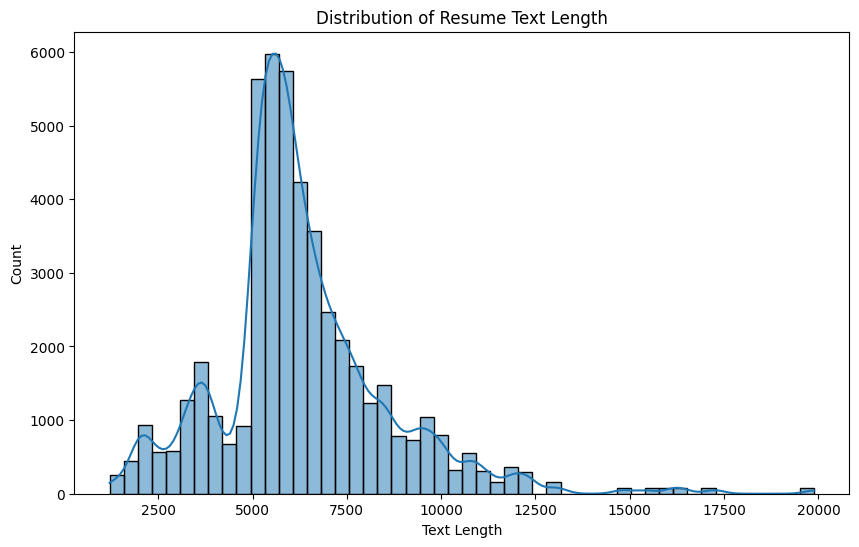

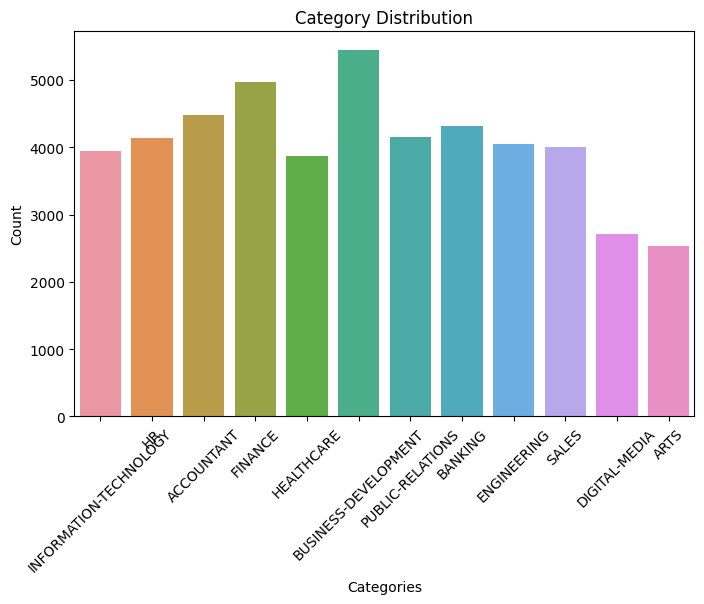

In [12]:
# Text Statistics
data['text_length'] = data['Resume_str'].apply(lambda x: len(str(x)))
data['word_count'] = data['Resume_str'].apply(lambda x: len(str(x).split()))
print(data[['text_length', 'word_count']].describe())

# Visualize text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['text_length'], bins=50, kde=True)
plt.title('Distribution of Resume Text Length')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

# Class Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Category', data=data)
plt.title('Category Distribution')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Handle missing values if any
data.dropna(inplace=True)

# Encode categorical variables like 'Category'
encoder = LabelEncoder()
data['Category'] = encoder.fit_transform(data['Category'])

In [13]:

#  Drop missing values
data.dropna(inplace=True)

# Encode categorical variables
encoder = LabelEncoder()
data['Category'] = encoder.fit_transform(data['Category'])

# Advanced text cleaning function
lemmatizer = WordNetLemmatizer()
# Drop missing values
data.dropna(inplace=True)

# Encode categorical variables
encoder = LabelEncoder()
data['Category'] = encoder.fit_transform(data['Category'])

# Advanced text cleaning function
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Abbreviations dictionary for job market
abbreviations = {
    "mgr": "manager",
    "sr": "senior",
    "jr": "junior",
    "asst": "assistant",
    "assoc": "associate",
    "dept": "department",
    "exp": "experience",
    "hr": "human resources",
    "acct": "account",
    "acctg": "accounting",
    "fin": "finance",
    "eng": "engineer",
    "engg": "engineering",
    "it": "information technology",
    "qa": "quality assurance",
    "dev": "development",
    "devops": "development operations",
    "proj": "project",
    "mktg": "marketing",
    "biz": "business",
    "comm": "communication",
    "adm": "administration",
    "sec": "secretary",
    "exec": "executive",
    "corp": "corporation",
    "intl": "international",
    "rep": "representative",
    "mfg": "manufacturing",
    "prod": "production",
    "purch": "purchasing",
    "sales": "sales",
    "cust": "customer",
    "svc": "service",
    "tech": "technical",
    "sup": "supervisor",
    "supv": "supervision",
    "log": "logistics",
    "inv": "inventory",
    "sch": "schedule",
    "edu": "education",
    "lang": "language",
    "pr": "public relations",
    "hrd": "human resources development",
    "cfo": "chief financial officer",
    "ceo": "chief executive officer",
    "coo": "chief operating officer",
    "cmo": "chief marketing officer",
    "cto": "chief technology officer",
    "cio": "chief information officer",
    "pmo": "project management office",
    "pmp": "project management professional",
    "ba": "business analyst",
    "bpm": "business process management",
    "ui": "user interface",
    "ux": "user experience",
    "svp": "senior vice president",
    "vp": "vice president",
    "gm": "general manager",
    "doe": "depends on experience",
    "r&d": "research and development",
    "seo": "search engine optimization",
    "sem": "search engine marketing",
    "smm": "social media marketing",
    "b2b": "business to business",
    "b2c": "business to consumer",
    "kpi": "key performance indicator",
    "roi": "return on investment",
    "saas": "software as a service",
    "paas": "platform as a service",
    "iaas": "infrastructure as a service",
    "crm": "customer relationship management",
    "erp": "enterprise resource planning",
    "sd": "software development",
    "pm": "project manager",
    "pa": "personal assistant",
    "exec": "executive",
    "fin": "finance",
    "hrm": "human resources management",
    "it": "information technology",
    "pr": "public relations",
    "qa": "quality assurance",
    "r&d": "research and development",
    "scm": "supply chain management",
    "seo": "search engine optimization",
    "smm": "social media marketing",
    "ux": "user experience",
    "ui": "user interface",
    "bi": "business intelligence",
    "dev": "development",
    "ops": "operations"
}


def expand_abbreviations(text, abbreviations):
    for abbr, expanded in abbreviations.items():
        text = re.sub(r'\b{}\b'.format(abbr), expanded, text)
    return text

def clean_text(text):
    # Expand abbreviations
    text = expand_abbreviations(text, abbreviations)
    # Convert to lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Remove stopwords and lemmatize
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply cleaning to 'Resume_str' and 'description' column s
data['Cleaned_Resume'] = data['Resume_str'].apply(clean_text)
data['Cleaned_Description'] = data['description'].apply(clean_text)


In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

max_len_resume = 2000  
max_len_description = 2000  

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=4000) 
tokenizer.fit_on_texts(data['Cleaned_Resume'].values.tolist() + data['Cleaned_Description'].values.tolist())

# Convert texts to sequences
X_resume = tokenizer.texts_to_sequences(data['Cleaned_Resume'].values)
X_description = tokenizer.texts_to_sequences(data['Cleaned_Description'].values)

# Pad sequences to ensure uniform input length
X_resume = pad_sequences(X_resume, maxlen=max_len_resume)
X_description = pad_sequences(X_description, maxlen=max_len_description)


# Combine resume and description sequences
X_combined = np.concatenate([X_resume, X_description], axis=-1)
y = data['ATS_Score'].values

# Ensure that all inputs match the model's expected input shape
assert X_combined.shape[1] == max_len_resume + max_len_description, "Input sequence length is incorrect"


In [15]:
vocab_size = len(tokenizer.word_index) + 1

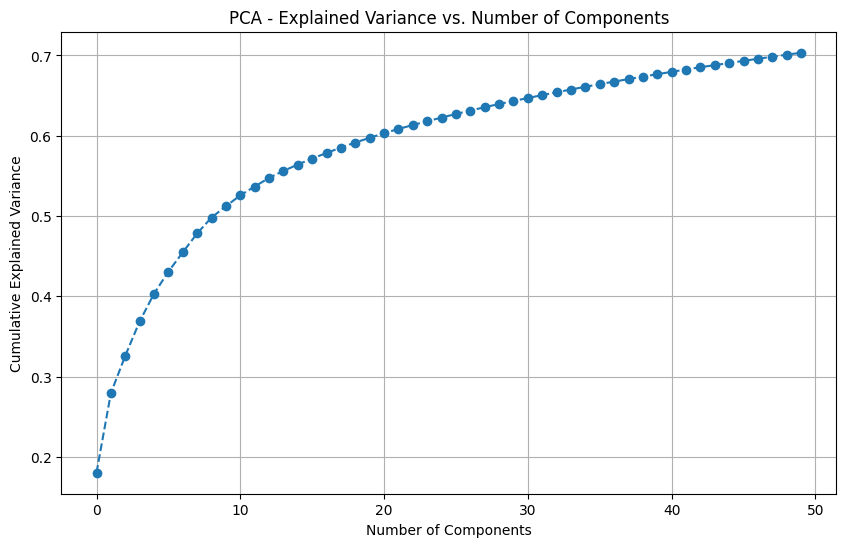

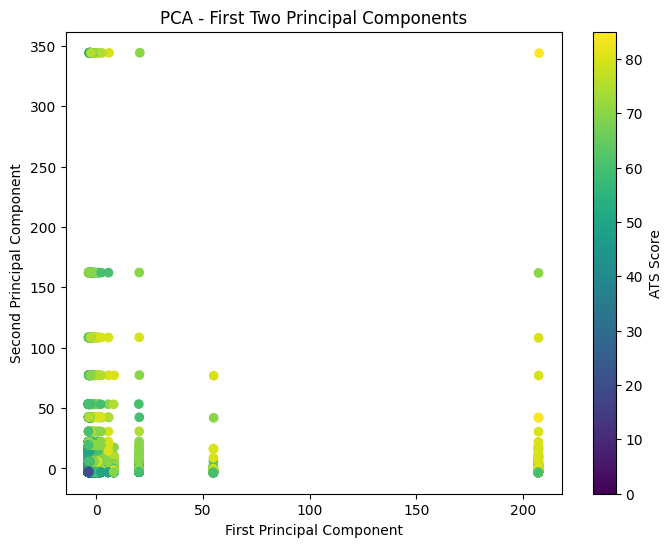

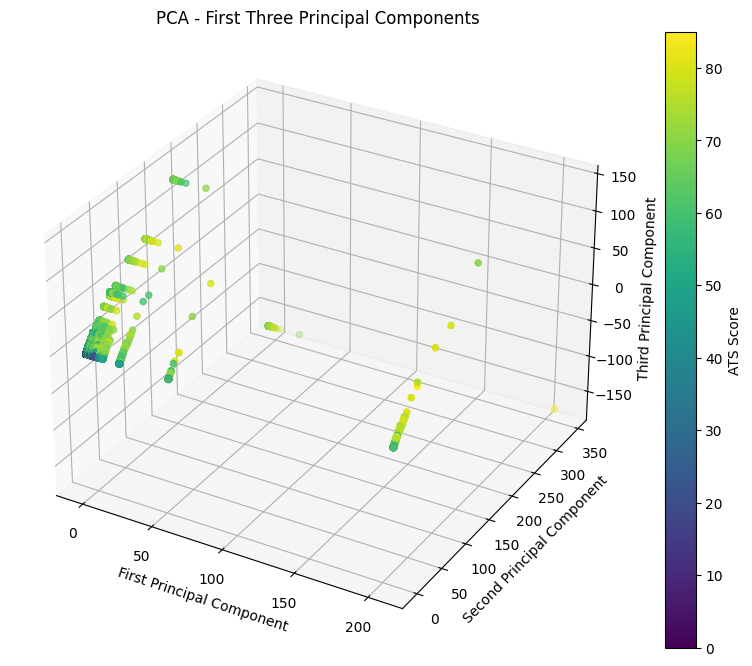

c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-p

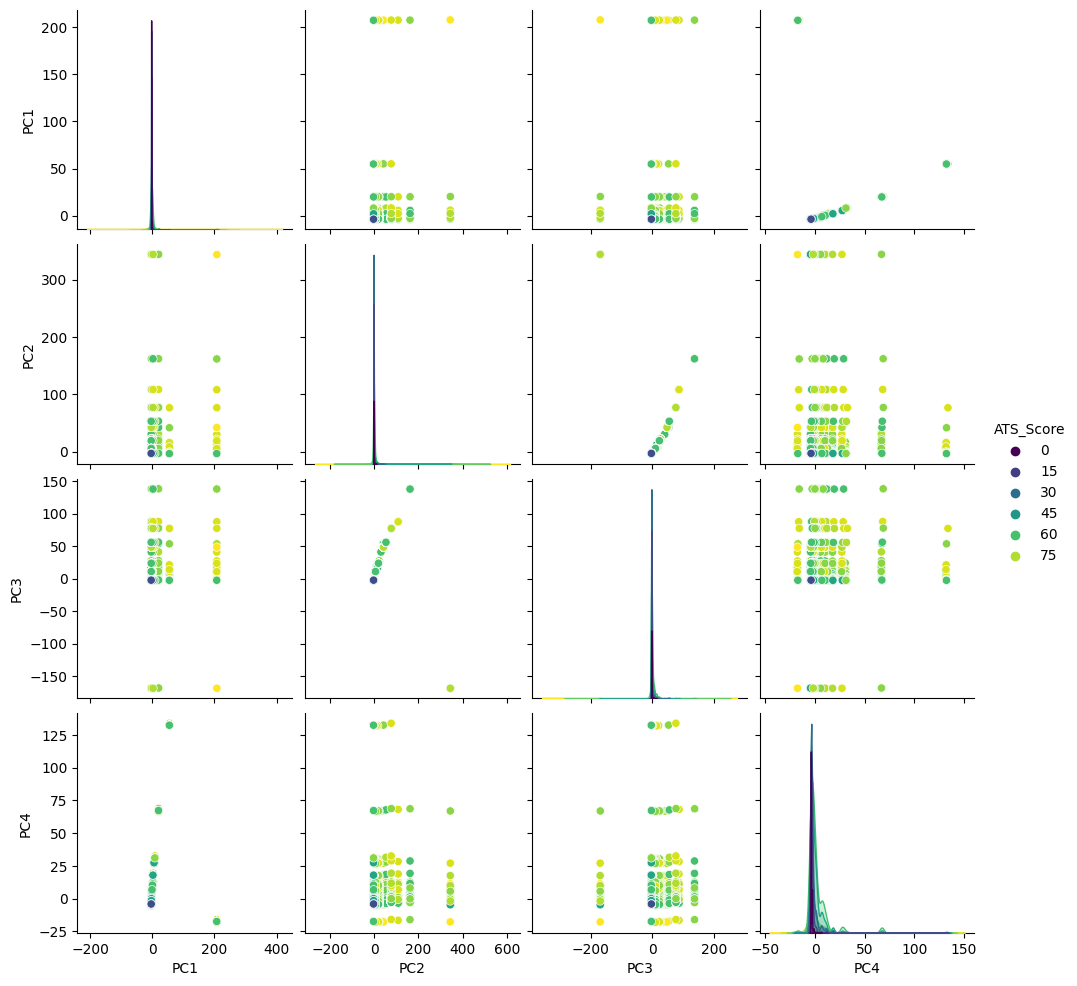

Loadings for the First Four Principal Components:
               PC1           PC2           PC3           PC4
0     7.957980e-19 -1.613161e-16  8.241444e-17 -3.124351e-17
1    -1.110176e-19 -9.339346e-17  4.359597e-15 -6.075817e-16
2     2.956614e-21  1.002708e-18 -3.635932e-16 -3.596465e-16
3    -3.560029e-21 -2.568080e-19  2.923468e-16  3.035868e-16
4    -2.470994e-21  1.302785e-19 -2.200810e-16 -3.073171e-16
...            ...           ...           ...           ...
3995  9.180814e-02  2.677986e-03  4.889462e-03 -1.895365e-01
3996  4.371744e-02  6.358022e-05 -9.157398e-04  1.651642e-01
3997  3.217205e-01 -4.613139e-03 -9.164549e-04 -3.990462e-02
3998 -8.910712e-02  8.679654e-04  3.050368e-04 -1.055518e-01
3999 -7.565767e-02 -2.940401e-04 -6.697790e-04 -4.238053e-02

[4000 rows x 4 columns]


In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

data['Combined_Text'] = data['Resume_str'] + ' ' + data['description']
X_combined = np.concatenate([X_resume, X_description], axis=-1)
y = data['ATS_Score']

# Standardize the data
scaler = StandardScaler()
X_combined_reshaped = X_combined.reshape(X_combined.shape[0], -1)
X_standardized = scaler.fit_transform(X_combined_reshaped)

# Apply PCA
n_components = 50  # Adjust the number of components based on your requirements
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_standardized)

# Explained Variance Plot
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

# 2D Visualization of the First Two Principal Components
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA - First Two Principal Components')
plt.colorbar(scatter, label='ATS Score')
plt.show()

# 3D Visualization of the First Three Principal Components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis')
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')
ax.set_title('PCA - First Three Principal Components')
fig.colorbar(scatter, ax=ax, label='ATS Score')
plt.show()

# Pair Plot of the First Four Principal Components
pca_df = pd.DataFrame(X_pca[:, :4], columns=[f'PC{i+1}' for i in range(4)])
pca_df['ATS_Score'] = y.values
sns.pairplot(pca_df, hue='ATS_Score', palette='viridis')
plt.show()

# Loadings for the First Principal Component
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_df = pd.DataFrame(loadings[:, :4], columns=[f'PC{i+1}' for i in range(4)])
print("Loadings for the First Four Principal Components:")
print(loading_df)



In [17]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Bidirectional, GRU, Dropout
from tensorflow.keras.metrics import AUC
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input,Embedding, Bidirectional, GRU, Dropout, Dense, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [18]:
# from keras.layers import Concatenate

# # Define model parameters
# max_len = 4000  # Adjust based on your data preprocessing (sum of max_len_resume and max_len_description)
# vocab_size = 20000  
# embedding_dim = 100
# units_1 = 64
# dense_units = 64
# learning_rate = 1e-3
# l2_reg = 1e-4

# def build_gru_model():
#     # Input for combined sequences
#     input_seq = Input(shape=(max_len,), dtype='int32', name='sequence_input')

#     # Embedding layer
#     x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(input_seq)
    
#     # First Bidirectional GRU Layer
#     x = Bidirectional(GRU(units_1, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(x)
#     x = BatchNormalization()(x)
    
#     # Second Bidirectional GRU Layer
#     x = Bidirectional(GRU(units_1 // 2, return_sequences=False, dropout=0.3, recurrent_dropout=0.3))(x)
#     x = BatchNormalization()(x)

#     # Dropout Layer
#     x = Dropout(0.5)(x)

#     # Additional Dense Layers
#     x = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg))(x)
#     x = Dropout(0.5)(x)
#     x = Dense(64, activation='relu', kernel_regularizer=l2(l2_reg))(x)
#     x = Dropout(0.5)(x)

#     # Output Layer
#     output = Dense(1, activation='linear')(x)  # 'linear' activation for regression

#     model = Model(inputs=input_seq, outputs=output)
#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mae'])
    
#     return model

# # Build the model
# model = build_gru_model()


In [19]:
from keras.layers import Input, Embedding, Bidirectional, GRU, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2

# Define model parameters
max_len = 4000  # Adjust based on your data preprocessing
vocab_size = 20000  
embedding_dim = 100
units_1 = 32  # Reduced from 64
dense_units = 32  # Reduced from 64
learning_rate = 1e-3
l2_reg = 1e-4

def build_gru_model():
    # Input for combined sequences
    input_seq = Input(shape=(max_len,), dtype='int32', name='sequence_input')

    # Embedding layer
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(input_seq)
    
    # Bidirectional GRU Layer
    x = Bidirectional(GRU(units_1, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(x)
    x = BatchNormalization()(x)
    
    # Global Average Pooling Layer
    x = GlobalAveragePooling1D()(x)

    # Dropout Layer
    x = Dropout(0.3)(x)  # Reduced dropout rate

    # Additional Dense Layers
    x = Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_reg))(x)  # Reduced dense units
    x = Dropout(0.3)(x)  # Reduced dropout rate

    # Output Layer
    output = Dense(1, activation='linear')(x)  # 'linear' activation for regression

    model = Model(inputs=input_seq, outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mae'])
    
    return model

# Build the model
model = build_gru_model()


c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [20]:
from sklearn.model_selection import train_test_split
import numpy as np

# Combine resume and description sequences
X_combined = np.concatenate([X_resume, X_description], axis=-1)

# Ensure that the combined data has the correct shape
assert X_combined.shape[1] == max_len_resume + max_len_description, "Input sequence length is incorrect"

# Split data into training, validation, and test sets
X_train_seq, X_test_seq, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42)

X_train_seq, X_val_seq, y_train, y_val = train_test_split(
    X_train_seq, y_train, test_size=0.2, random_state=42)

print(f"Training set size: {X_train_seq.shape[0]}")
print(f"Validation set size: {X_val_seq.shape[0]}")
print(f"Test set size: {X_test_seq.shape[0]}")


Training set size: 31110
Validation set size: 7778
Test set size: 9723


In [28]:


# from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define callbacks for early stopping, learning rate reduction, and checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model with callbacks
history = model.fit(
    X_train_seq, y_train,
    epochs=5,  # Example value, can be adjusted
    batch_size=64,  # Example value, can be adjusted
    validation_data=(X_val_seq, y_val),
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test_seq, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")


Epoch 1/5
487/487 ━━━━━━━━━━━━━━━━━━━━ 8506s 17s/step - loss: nan - mae: 46.8516 - val_loss: nan - val_mae: 46.8617 - learning_rate: 4.0000e-05
Epoch 2/5
487/487 ━━━━━━━━━━━━━━━━━━━━ 8414s 17s/step - loss: nan - mae: 46.8278 - val_loss: nan - val_mae: 46.8434 - learning_rate: 4.0000e-05
Epoch 3/5
487/487 ━━━━━━━━━━━━━━━━━━━━ 7662s 16s/step - loss: nan - mae: 46.7395 - val_loss: nan - val_mae: 46.8252 - learning_rate: 4.0000e-05
Epoch 4/5
487/487 ━━━━━━━━━━━━━━━━━━━━ 9054s 19s/step - loss: nan - mae: 46.6159 - val_loss: nan - val_mae: 46.8070 - learning_rate: 4.0000e-05
Epoch 5/5
487/487 ━━━━━━━━━━━━━━━━━━━━ 10821s 22s/step - loss: nan - mae: 46.7904 - val_loss: nan - val_mae: 46.7888 - learning_rate: 4.0000e-05
304/304 ━━━━━━━━━━━━━━━━━━━━ 70s 230ms/step - loss: nan - mae: 46.6456
Test Loss: nan
Test MAE: 46.95134735107422


In [27]:
# Save the entire model to a file
model.save('bigrubasic.keras')


In [ ]:
import numpy as np
import shap
from tensorflow import keras
import gc

# Load the model
model = keras.models.load_model('model.keras')

# Assuming X_train_seq is your training data
X_train_seq = np.array(X_train_seq)

# Reshape or pad X_train_seq to (n_samples, 4000)
if X_train_seq.shape[1] < 4000:
    padding = np.zeros((X_train_seq.shape[0], 4000 - X_train_seq.shape[1]))
    X_train_seq = np.concatenate((X_train_seq, padding), axis=1)
elif X_train_seq.shape[1] > 4000:
    X_train_seq = X_train_seq[:, :4000]

# Sample background data to reduce the size
K = 50  # Further reduced background sample size
background_data = shap.sample(X_train_seq, K)

# Use DeepExplainer instead of KernelExplainer
explainer = shap.DeepExplainer(model, background_data)

# Calculate SHAP values for the training data in smaller batches
batch_size = 5  # Smaller batch size
shap_values = []

for i in range(0, X_train_seq.shape[0], batch_size):
    batch = X_train_seq[i:i + batch_size]
    shap_values_batch = explainer.shap_values(batch)
    shap_values.append(shap_values_batch)
    gc.collect()  # Free up memory after each batch

# Concatenate the SHAP values from all batches
shap_values = np.concatenate(shap_values, axis=0)

# Visualize the SHAP values for the first instance
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_train_seq[0])


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


MemoryError: Unable to allocate 11.0 GiB for an array with shape (7400, 400000) and data type int32

In [ ]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()


NameError: name 'X_test' is not defined

In [ ]:
# Save the model
model.save('advanced_rnn_model.h5')

# To load the model later
# from tensorflow.keras.models import load_model
# model = load_model('advanced_rnn_model.h5')


////////////////////////////////

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Adjust the number of epochs as needed
    batch_size=32,  # Adjust the batch size as needed
    callbacks=[early_stopping],  # Include early stopping if necessary
    verbose=1
)



Epoch 1/50


ValueError: in user code:

    File "c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_11" is incompatible with the layer: expected shape=(None, 6000), found shape=(None, 12000)


In [ ]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")


ValueError: in user code:

    File "c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1972, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1956, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1944, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1850, in test_step
        y_pred = self(x, training=False)
    File "c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_10" is incompatible with the layer: expected shape=(None, 6000), found shape=(None, 3000)


In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()


In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

# Print model performance
print(f"Training MAE: {history.history['mae'][-1]}")
print(f"Validation MAE: {history.history['val_mae'][-1]}")
print(f"Training AUC: {history.history['auc'][-1]}")
print(f"Validation AUC: {history.history['val_auc'][-1]}")

# Now, your DataFrame 'data' has the cleaned, processed columns and you have checked the separability of the features.
print(data.head())

???????

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len_resume = 1500  # Define maximum length of sequences for resume
max_len_description = 1500  # adjust as needed

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Resume_str'] + ' ' + data['description'])

X_resume = tokenizer.texts_to_sequences(data['Resume_str'])
X_description = tokenizer.texts_to_sequences(data['description'])

X_resume = pad_sequences(X_resume, maxlen=max_len_resume)
X_description = pad_sequences(X_description, maxlen=max_len_description)

X_combined = np.concatenate([X_resume, X_description], axis=-1)
y = data['ATS_Score'].values



In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

In [ ]:
import shutil
import os

# Define the directory where the tuner files are saved
tuner_dir = 'my_dir/gru_ats'

# Check if the directory exists
if os.path.exists(tuner_dir):
    # Delete the directory and all its contents
    shutil.rmtree(tuner_dir)
    print(f"Cleared cache and deleted directory: {tuner_dir}")
else:
    print(f"Directory does not exist: {tuner_dir}")


Directory does not exist: my_dir/gru_ats


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional, GRU, Embedding
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
import keras_tuner as kt

# Sample data preparation (assuming you have your data as dataframes X_train and y_train)

max_len = 1500  # Adjust based on your data preprocessing
vocab_size = 20000  # Example value, replace with your actual vocab size

# Define a function to build the GRU model with hyperparameter tuning
def build_gru_model(hp):
    input_seq = Input(shape=(2 * max_len,), dtype='int32')

    # Embedding layer
    embedding_dim = hp.Choice('embedding_dim', values=[50, 100])
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=2 * max_len)(input_seq)

    # Tuning the number of units in the GRU layers
    units_1 = hp.Int('units_1', min_value=32, max_value=64, step=32)

    # GRU Layer
    gru_output = Bidirectional(GRU(units_1, return_sequences=False))(x)

    # Tuning the number of units in the Dense layers
    dense_units = hp.Int('dense_units', min_value=32, max_value=64, step=32)

    x = Dense(dense_units, activation='relu')(gru_output)
    x = Dropout(0.2)(x)
    output = Dense(1, activation='linear')(x)  # Use 'linear' for regression tasks

    model = Model(inputs=input_seq, outputs=output)
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])), loss='mean_squared_error', metrics=['mae'])
    
    return model

# Define a Keras Tuner tuner object
tuner_gru = kt.Hyperband(
    build_gru_model,
    objective='val_mae',
    max_epochs=3,
    factor=3,
    directory='my_dir',
    project_name='gru_ats'
)

# Use only 10% of the original training data for hyperparameter search
X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, train_size=0.1, random_state=42)

# Run the hyperparameter search
tuner_gru.search(X_train_small, y_train_small, epochs=3, validation_split=0.2)

# Get the optimal hyperparameters
best_hps_gru = tuner_gru.get_best_hyperparameters(num_trials=1)[0]

print(f"Best hyperparameters for GRU: {best_hps_gru.values}")

# Build the best model with optimal hyperparameters
model_gru_best = tuner_gru.hypermodel.build(best_hps_gru)

# Train the model on the entire dataset
history_gru_best = model_gru_best.fit(X_train, y_train, epochs=10, validation_split=0.2)

# Dummy data for evaluation
# Replace X_test and y_test with your actual test data
X_test = np.random.randint(0, vocab_size, size=(200, 2 * max_len))
y_test = np.random.rand(200)

# Evaluate the model
loss_gru_best, mae_gru_best = model_gru_best.evaluate(X_test, y_test)
print(f"Best Bidirectional GRU - Test Loss: {loss_gru_best}, Test MAE: {mae_gru_best}")


Trial 6 Complete [00h 00m 50s]
val_mae: 46.539947509765625

Best val_mae So Far: 14.908382415771484
Total elapsed time: 00h 03m 36s
Best hyperparameters for GRU: {'embedding_dim': 50, 'units_1': 64, 'dense_units': 32, 'learning_rate': 0.001, 'tuner/epochs': 3, 'tuner/initial_epoch': 1, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0000'}
Epoch 1/10
164/164 [==============================] - 220s 1s/step - loss: 749.2808 - mae: 21.6845 - val_loss: 307.4756 - val_mae: 14.9070
Epoch 2/10
164/164 [==============================] - 312s 2s/step - loss: 362.1028 - mae: 15.5971 - val_loss: 302.6043 - val_mae: 14.4529
Epoch 3/10
164/164 [==============================] - 327s 2s/step - loss: 298.0518 - mae: 13.8877 - val_loss: 194.9183 - val_mae: 11.0819
Epoch 4/10
164/164 [==============================] - 329s 2s/step - loss: 229.7562 - mae: 12.1381 - val_loss: 168.3943 - val_mae: 10.5354
Epoch 5/10
164/164 [==============================] - 318s 2s/step - loss: 196.8682 - mae: 11

In [ ]:
# Build the best model with optimal hyperparameters
model_gru_best = tuner_gru.hypermodel.build(best_hps_gru)

# Train the model
history_gru_best = model_gru_best.fit(X_train, y_train, epochs=10, validation_split=0.2)

# Evaluate the model
loss_gru_best, mae_gru_best = model_gru_best.evaluate(X_test, y_test)
print(f"Best Bidirectional GRU - Test Loss: {loss_gru_best}, Test MAE: {mae_gru_best}")

Epoch 1/10
164/164 [==============================] - 364s 2s/step - loss: 917.1678 - mae: 24.4611 - val_loss: 307.3250 - val_mae: 14.8909
Epoch 2/10
164/164 [==============================] - 333s 2s/step - loss: 369.1051 - mae: 15.6922 - val_loss: 305.4588 - val_mae: 14.7382
Epoch 3/10
164/164 [==============================] - 353s 2s/step - loss: 350.8151 - mae: 15.2900 - val_loss: 215.4918 - val_mae: 12.1437
Epoch 4/10
164/164 [==============================] - 353s 2s/step - loss: 240.3563 - mae: 12.2897 - val_loss: 168.2457 - val_mae: 10.4036
Epoch 5/10
164/164 [==============================] - 352s 2s/step - loss: 206.7831 - mae: 11.3438 - val_loss: 138.9679 - val_mae: 9.0167
Epoch 6/10
164/164 [==============================] - 349s 2s/step - loss: 181.1702 - mae: 10.6044 - val_loss: 129.2982 - val_mae: 8.8201
Epoch 7/10
164/164 [==============================] - 353s 2s/step - loss: 167.4967 - mae: 10.1080 - val_loss: 120.8301 - val_mae: 8.5528
Epoch 8/10
164/164 [==========

In [ ]:
# Predict ATS scores on the test set
y_pred = model_gru_best.predict(X_test)

7/7 [==============================] - 3s 385ms/step


7/7 [==============================] - 3s 379ms/step - loss: 1701.9254 - mae: 40.5885
Test Loss: 1701.9254150390625, Test MAE: 40.588478088378906


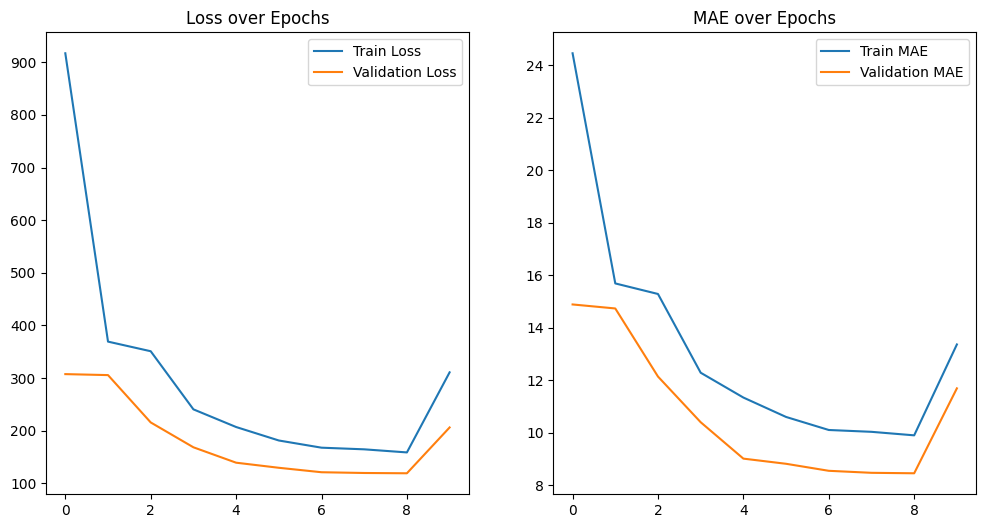

In [ ]:
# Evaluate the model
loss, mae = model_gru_best.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_gru_best.history['loss'], label='Train Loss')
plt.plot(history_gru_best.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_gru_best.history['mae'], label='Train MAE')
plt.plot(history_gru_best.history['val_mae'], label='Validation MAE')
plt.title('MAE over Epochs')
plt.legend()

plt.show()
